In [2]:
import numpy as np

wigth = 8000
height = 4000

points_pano = np.array(
    [[2491, 533], 
     [519, 974], 
     [1340, 634], 
     [1066, 715], 
     [1067, 807], 
     [1339, 721]], dtype='float32')

points_3d = np.array(
    [
        [-805465, 261912, 176528],
        [-999003, 271359, 176466],
        [-878350, 265396, 150586],
        [-903028, 266616, 150125],
        [-902612, 266558, 127889],
        [-878333, 265380, 127893],
    ]
)

point_of_view = np.array(
    #[[-897550, 188829, -5380]],
    [[-927669, 191009, -5639]],
)

# Show point cloud


In [3]:
import matplotlib.pyplot as plt


def draw_3d_points_with_pov(points: np.ndarray, pov: np.ndarray = None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = points.T[0]
    ys = points.T[1]
    zs = points.T[2]
    ax.scatter(xs, ys, zs, marker='o')
    
    if pov is not None:
        xs = pov.T[0]
        ys = pov.T[1]
        zs = pov.T[2]
        ax.scatter(xs, ys, zs, marker='^')
        

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

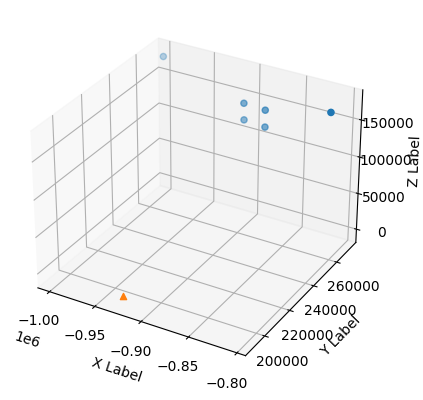

In [4]:
draw_3d_points_with_pov(points_3d, point_of_view)

# Find latitudes and longitudes of 3D points

In [5]:
point_vectors = points_3d - np.concatenate([point_of_view] * points_3d.shape[0], axis=0)
point_vectors = point_vectors.astype('float32')
print(point_vectors)

point_vectors_xy = point_vectors.copy()
point_vectors_xy[:, 2] = 0

point_vectors_z = point_vectors.copy()
point_vectors_z[:, 0:2] = 0

latitudes = []
longitudes = []

for i in range(point_vectors.shape[0]):
    pt_vec = point_vectors[i]
    pt_vec_xy = point_vectors_xy[i]
    
    if np.linalg.norm(pt_vec) == 0:
        latitude = 0
        longitude = 0
    elif np.linalg.norm(pt_vec_xy) == 0 and pt_vec[2] > 0:
        latitude = 0
        longitude = 0
    elif np.linalg.norm(pt_vec_xy) == 0 and pt_vec[2] < 0:
        latitude = np.pi
        longitude = 0
    else:    
        cos_latitude = pt_vec[2] / np.linalg.norm(pt_vec)
        latitude = np.arccos(cos_latitude)
        
        cos_longitude = pt_vec[0] / (np.linalg.norm(pt_vec_xy))
        if pt_vec[1] >= 0:
            longitude = np.arccos(cos_longitude)
        else:
            longitude = 2 * np.pi - np.arccos(cos_longitude)
    
    latitudes.append(latitude)
    longitudes.append(longitude)


points_3d_projected = np.array([longitudes, latitudes]).T
points_3d_projected[:, 0] = points_3d_projected[:, 0] / (2 * np.pi) * wigth
points_3d_projected[:, 1] = points_3d_projected[:, 1] / np.pi * height

print(points_3d_projected)

[[122204.  70903. 182167.]
 [-71334.  80350. 182105.]
 [ 49319.  74387. 156225.]
 [ 24641.  75607. 155764.]
 [ 25057.  75549. 133528.]
 [ 49336.  74371. 133532.]]
[[ 669.3865   839.9143 ]
 [2924.4082   678.70154]
 [1254.5643   660.87366]
 [1598.861    601.0075 ]
 [1592.2466   684.42487]
 [1254.2361   750.15894]]


# Find offset `alpha`

In [6]:
n = len(points_3d_projected)
alpha = (points_pano[:, 0] - points_3d_projected[:, 0]).sum() / n

print(alpha)

-245.28377278645834


# Show original pano points with projected and shifted points

In [7]:
import cv2

img = np.ones((height, wigth, 3), dtype='uint8') * 128
# img = cv2.imread(r'C:\Users\HP\Downloads\Telegram Desktop\pano_000005_000025.jpg')

for i in range(points_3d_projected.shape[0]):
    xp, yp = points_3d_projected[i]
    x, y = points_pano[i]
    cv2.circle(img, (int(xp + alpha), int(yp)), 20, (0, 255, 0), -1)
    cv2.circle(img, (int(x), int(y)), 25, (0, 0, 255), -1)


cv2.imshow('img', cv2.resize(img, (800, 400)))
cv2.waitKey()

-1